## Baseline Classifier

In [1]:
%pwd
%cd d:\\Murgi\\code\\memes2024\\meme-research-2024
%pwd


d:\Murgi\code\memes2024\meme-research-2024


d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'd:\\Murgi\\code\\memes2024\\meme-research-2024'

Import libs

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage import feature
from PIL import Image
from joblib import Parallel, delayed
import multiprocessing
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, f1_score
import mlflow
import constants
import os


### Load data

In [3]:
meme_df = pd.read_parquet("./data\meme_entries.parquet")
meme_df

,id,template_name,path,phash
0,0-days-without-lenny-simpsons,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,0fe9b236e884fc38
1,0-days-without-Lenny-Simpsons_23,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07e5ba2ee806fe30
2,0-days-without-Lenny-Simpsons_1,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,1fed3226e804fe38
3,0-days-without-Lenny-Simpsons_24,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07e1b83ee886fa38
4,0-days-without-Lenny-Simpsons_10,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,17e5b22ee806fe30
...,...,...,...,...
124196,skeleton-computer-84,skeleton-computer,D:/Memes2024/Skeleton-Computer/skeleton-comput...,e1e68b1929253d3d
124197,nick-young-178,nick-young,D:/Memes2024/Nick-Young/nick-young-178.jpg,4bd5913e14da4e55
124198,success-kid-original-196,success-kid-original,D:/Memes2024/Success-Kid-Original/success-kid-...,1d1d301f32c3f2e3
124199,Wrong-Neighboorhood-Cats_23,wrong-neighboorhood-cats,D:/Memes2024/Wrong-Neighboorhood-Cats/Wrong-Ne...,a950535053abb3bb


In [6]:
img_flip_features = np.load(r"D:\Murgi\code\memes2024\meme-research-2024\data\mlr\baseline_features.npy")
img_flip_features.shape

(124201, 1052)

### Feature extraction pipeline

Extracts:
- RGB historgram
- Grayscale histogram
- LBP features

In [5]:


def extract_features(image_path):
    # Check if the file is a GIF
    if image_path.endswith('.gif') or image_path.endswith('.GIF'):
        img = Image.open(image_path)
        img = img.convert('RGB') # Convert to RGB
        img = np.array(img) # Convert to NumPy array
    else:
        img = cv2.imread(image_path)
        if img is None or img.size == 0:
            print(f"Failed to load image at path {image_path}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to standard RGB

    # convert image to HSV and calculate HSV histogram
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_features = []
    for i in range(3):  # for each channel
        hist = cv2.calcHist([hsv_img], [i], None, [256], [0, 256])
        hsv_features.extend(hist.flatten())

    # convert image to grayscale and calculate grayscale histogram
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grayscale_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    grayscale_features = grayscale_hist.flatten()

    # calculate LBP features
    lbp = feature.local_binary_pattern(gray, P=24, R=8, method="uniform")
    n_points = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_features = lbp_hist.astype("float")
    lbp_features /= (lbp_features.sum() + 1e-7)  # normalize histogram

    # Check the length of the LBP features and append a zero if necessary, to have a consistent length of features in all images
    if len(lbp_features) == 27:
        lbp_features = np.append(lbp_features, 0)

    # concatenate all features into a single feature vector
    feature_vector = np.hstack([hsv_features, grayscale_features, lbp_features])

    # Debug only:
    # print("HSV features shape:", len(hsv_features))
    # print("Grayscale features shape:", len(grayscale_features))
    # print("LBP features shape:", len(lbp_features))

    return feature_vector

# example usage:
# image_path = 'meme.jpg'
# features = extract_features(image_path)

### Preprocessing

In [8]:
sm_df = pd.read_parquet(r"D:\Murgi\code\meme-evaluator\final-predictions\evaluated_sm_images.parquet")

image_paths = sm_df['path'].tolist()

Extract features from the dataset

In [9]:
from tqdm.contrib.concurrent import thread_map  # or thread_map

# Get number of cores
num_cores = multiprocessing.cpu_count() - 1

# test_image_paths = image_paths[:1]

# Use joblib to parallelize feature extraction
start = time.time()
features = thread_map(extract_features, image_paths, max_workers=num_cores)
end = time.time()
print(f"Time taken to extract features from {len(image_paths)} images: {end-start:.2f} seconds")


  0%|          | 0/330 [00:00<?, ?it/s]

Time taken to extract features from 330 images: 22.88 seconds


In [12]:
features = np.array(features)
features.shape

X_test = features

## Fit the model

In [11]:
X = img_flip_features
X = X.astype('float32')

labelencoder = LabelEncoder()
meme_df['template_id'] = labelencoder.fit_transform(meme_df['template_name'])

y = meme_df['template_id'].copy()


In [14]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

train_index, test_index = next(skf.split(X, y))
X_train = X[train_index]
y_train = np.array(y)[train_index]

clf= LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='lbfgs', random_state=42)

clf.fit(X_train, y_train)

d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

## Make predictions on the SM data

In [15]:
y_pred = clf.predict(X_test)

-----

# Evaluate the classifier

Add predictions to the df

In [16]:
sm_df['encoded_predictions'] = y_pred
sm_df['predictions'] = sm_df.loc[:,'encoded_predictions'].apply(lambda x: labelencoder.inverse_transform([x])[0] if x != -1 else 'templateless')
sm_df.to_parquet(r"D:\Murgi\code\memes2024\meme-research-2024\reports\mlr\sm_predictions.parquet")   

In [17]:
sm_df['ground_truth_binary'] = sm_df['ground_truth'].apply(lambda x: 1 if x != 'templateless' else 0)
sm_df['predictions_binary'] = sm_df['predictions'].apply(lambda x: 1 if x != 'templateless' else 0)
sm_df

,id,source,path,ground_truth,phash,encoded_predictions,predictions,ground_truth_binary,predictions_binary
0,959099244454225_added-23590,facebook,D:/Murgi/Facebook2023/Facebook2023/95909924445...,templateless,730d2df2855f3087,57,anime-boy-running,0,1
1,562359021251691_added-37275,facebook,D:/Murgi/Facebook2023/Facebook2023/56235902125...,templateless,01b6fe1d14e3c393,194,children-scared-of-rabbit,0,1
2,2022.10.29_846,reddit,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,templateless,5da1539b314ce91e,804,sad-pablo-escobar,0,1
3,2021.12.15_469,reddit,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,templateless,63639c893676c396,607,mega-rage-face,0,1
4,959099244454225_added-13624,facebook,D:/Murgi/Facebook2023/Facebook2023/95909924445...,templateless,1fb4e64334c33ca6,1020,troll-face,0,1
...,...,...,...,...,...,...,...,...,...
325,2019_6-7481,twitter,D:/Murgi/Twitter2023/2019_6-7481.jpg,templateless,e38fb4466d645352,1019,trojan-horse,0,1
326,400452145335749_added-11850,facebook,D:/Murgi/Facebook2023/Facebook2023/40045214533...,templateless,0bbdf5534707c708,33,always-has-been,0,1
327,DankMagicMemes_added-6035,facebook,D:/Murgi/Facebook2023/Facebook2023/DankMagicMe...,templateless,83f76c09f80f09d3,933,stop-it-patrick-youre-scaring-him,0,1
328,2022.06.11_916,reddit,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,templateless,2913c36d53593795,762,ptsd-chihuahua,0,1


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       253
           1       0.23      1.00      0.38        77

    accuracy                           0.23       330
   macro avg       0.12      0.50      0.19       330
weighted avg       0.05      0.23      0.09       330



d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

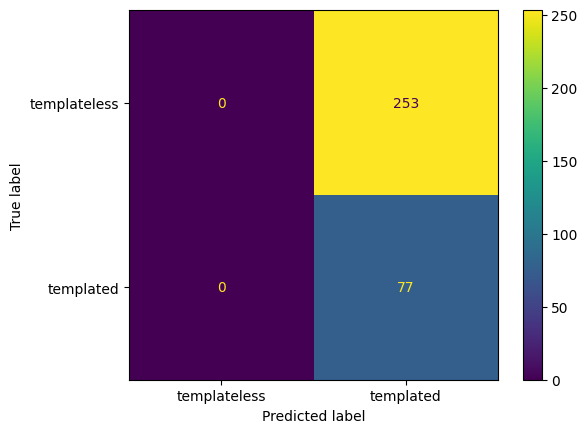

In [18]:
from sklearn.metrics import classification_report
# import confusion_matrix_pretty_print
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(sm_df['ground_truth_binary'], sm_df['predictions_binary']))

cm = confusion_matrix(sm_df['ground_truth_binary'], sm_df['predictions_binary'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['templateless', 'templated'])
disp.plot()
plt.show()